# KNN Classification and Logistic Regression to classify glass types

This notebook contains two main techniques for the classification of glass samples from a Kaggle dataset: https://www.kaggle.com/uciml/glass. We take a multidimensional approach with K Nearest Neighbours classfication, and later on build a logistic regression model from scratch for univariate classification. This is then compared to scikit-learn's prebuilt logistic regression implementation, and accuracies are compared.

# 1. KNN Classification

Initially, we load the data into the notebook:

In [20]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score

dataset = pd.read_csv("glass.csv") # importing the data from the .csv file
dataset.sort_values('Al', inplace=True) # sort by ascending "Al" values
dataset.head() # print the first 5 rows

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
21,1.51966,14.77,3.75,0.29,72.02,0.03,9.00,0.0,0.00,1
184,1.51115,17.38,0.00,0.34,75.41,0.00,6.65,0.0,0.00,6
39,1.52213,14.21,3.82,0.47,71.77,0.11,9.57,0.0,0.00,1
38,1.52213,14.21,3.82,0.47,71.77,0.11,9.57,0.0,0.00,1
50,1.52320,13.72,3.72,0.51,71.75,0.09,10.06,0.0,0.16,1


First we write a function ```distance(p, data, D)``` that returns an array of distances between the point ```p``` and each point in the dataset ```data```, where the array is a ```D```-dimensional Euclidean distance.

In [21]:
def euclidean(a,b):
    if len(a) != len(b):
        return "Lengths are unequal"
    else:
        tot = 0
    for i in range(len(a)):
        tot += (b[i] - a[i])**2
    ans = np.sqrt(tot)
    return ans
    
#ans = euclidean([3,4,4],[0,0])
#print(ans)

#feed one point which is an array, and data which is a matrix with one row per data point and one column per attribute
def distance(p, data, D):
    values = []
    text = ""
    for i in range(len(data)):
        if len(data[i]) != len(p):
            text = "Lengths are unequal for point"+str(i+1)
            return text
        elif (len(data[i]) != D) or (len(p) != D):
            text = "D metric is different for point"+str(i+1)
            return text
        else:
            values.append([euclidean(p,data[i]),i]) #returns the Euclidean distance and index to data point i
        values = sorted(values)
    return values

p = [1,2,3,4]
data = [[0,2,0,0],[0,0,0,1],[4,0,0,0],[0,0,0,0]]

ans = distance(p, data, 4)
print(ans)
#print(np.column_stack([p,data])) 

[[4.795831523312719, 1], [5.0990195135927845, 0], [5.477225575051661, 3], [6.164414002968976, 2]]


Split the data into a training set and a test set at a ratio of 80:20.

In [22]:
training_data = dataset.sample(frac = 0.8)
test_data = dataset.sample(frac = 0.2)

We can plot the content of different elements against each other. As a trail, we plot the "Mg" training values against the "Si" training values. Points with non-zero values are red, and zeroes are black. The test points are in blue.

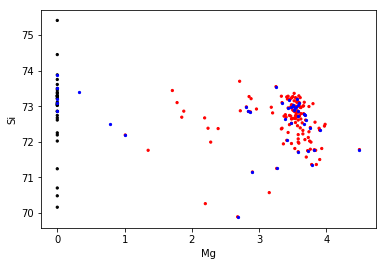

*******TRAINING*******
          RI     Na    Mg    Al     Si     K     Ca    Ba    Fe  Type
80   1.51592  12.86  3.52  2.12  72.66  0.69   7.97  0.00  0.00     2
95   1.51860  13.36  3.43  1.43  72.26  0.51   8.60  0.00  0.00     2
101  1.51730  12.35  2.72  1.63  72.87  0.70   9.23  0.00  0.00     2
200  1.51508  15.15  0.00  2.25  73.50  0.00   8.34  0.63  0.00     7
55   1.51769  12.45  2.71  1.29  73.70  0.56   9.06  0.00  0.24     1
151  1.52127  14.32  3.90  0.83  71.50  0.00   9.49  0.00  0.00     3
112  1.52777  12.64  0.00  0.67  72.02  0.06  14.40  0.00  0.00     2
86   1.51569  13.24  3.49  1.47  73.25  0.38   8.03  0.00  0.00     2
14   1.51763  12.61  3.59  1.31  73.29  0.58   8.50  0.00  0.00     1
179  1.51852  14.09  2.19  1.66  72.67  0.00   9.32  0.00  0.00     6
75   1.51590  13.02  3.58  1.51  73.12  0.69   7.96  0.00  0.00     2
210  1.51685  14.92  0.00  1.99  73.06  0.00   8.40  1.59  0.00     7
191  1.51602  14.85  0.00  2.38  73.28  0.00   8.76  0.64  0.09    

In [23]:
import matplotlib.pyplot as plt

colors = np.where(training_data["Mg"]==0,'k','r')
ax1 = training_data.plot.scatter("Mg","Si",5, c=colors)
ax2 = test_data.plot.scatter("Mg", "Si", 5, 'b', ax=ax1)
plt.show()

print("*******TRAINING*******")
print(training_data)
print("*******TEST*******")
print(test_data)

Write a function ```knn_search(p, trainingset, k)``` that returns the indices of the ```k``` closest neighbours around the point ```p```, use the ```distance``` function implemented in previous task!

In [24]:
def knn_search(p, trainingset, k):
    data = distance(p, trainingset, len(p))
    indices = []
    distances = []
    for dist in data:
        indices.append(dist[1])
        distances.append(dist[0])
    return indices[0:k]

p = [1,2,3,4]
data = [[0,2,0,0],[0,0,0,1],[4,0,0,0],[0,0,0,0]]

ans = knn_search(p,data,4)
print(ans)

[1, 0, 3, 2]


We then write a function (with the help of a library) that looks at the labels of the closest neighbours, and chooses the most frequent label as its output. This is your predicted value for the point ```p```.

In [25]:
from collections import Counter

#have to input a table of 2 columns (values and labels)
def label(labels):
    #values = data[0]
    #labels = data[1]
    label = Counter(labels).most_common(1)
#   label,freq = labels.most_common(1)
#    print(str(label[0][0])+" is the most common, seen "+str(label[0][1])+" times.")
    return label

labels = [3,3,6,2,7,9,3,1,4,6,8,9,3,6,8,4,8,3,6,0]
label(labels)

[(3, 5)]

Use the code to make a prediction about the labels in the testing set, calculate the accuracy, sensitivity, and specificity of this model.

In [26]:
#convert dataframes into matrices for easier manipulation
trainingmat = np.array(training_data)
testmat = np.array(test_data)

k = 6 #number of nearest neighbours to sample

#predicted types of the test data
pred_types = [] #predicted type of each sample
test_indices = [] #indices of each sample in the test_data dataframe
accurate = [] #array showing which test samples were classified correctly

for index,test in test_data.iterrows():
    test_indices.append(index) #just for admin
    
    p = np.array(test) #converts each row of test_data into an array, to use for the knn_search function
    ans = knn_search(p,trainingmat,k) #returns k nearest neighbours' index within the trainingmat array.
    neighbour_indices = training_data.index[ans] #converts trainingmat indices into training_data (dataframe) indices
    types = np.array(training_data["Mg"][neighbour_indices]) #finds the 'Mg' of each data sample, based on training_data indices
    lab_freq = label(types) #finds whether it classify test sample as 0 or Mg value
    if lab_freq[0][0] == 0:
        assigned_val = 0
    else:
        assigned_val = lab_freq[0][0]
    pred_types.append(assigned_val) #appends the assigned type to an array, one for each test sample
    
fin = np.column_stack([np.array(test_data["Mg"]),pred_types])
#print(fin)

#calculating accuracy, sensitivity and specifity
corr_pred,true_pos,false_pos,true_neg,false_neg = [0,0,0,0,0]
for i in range(len(pred_types)):
    if (np.array(test_data["Mg"])[i] != 0) and (pred_types[i] != 0):
        true_pos += 1
        corr_pred += 1
    elif (np.array(test_data["Mg"])[i] == 1) and (pred_types[i] == 0):
        false_pos += 1
    elif (np.array(test_data["Mg"])[i] == 0) and (pred_types[i] == 1):
        false_neg += 1
    elif (np.array(test_data["Mg"])[i] == 0) and (pred_types[i] == 0):
        true_neg += 1
        corr_pred += 1

accuracy = corr_pred/(len(pred_types))
sensitivity = true_pos/(true_pos+false_neg)
specifity = true_neg/(true_neg+false_pos)

print([accuracy,sensitivity,specifity])
#we get 97% accuracy
    
#Tried to do the exercise by classifying it into types instead, but then what counts as positive/negative as you have multiple variables to classify it into?
    
    
    

[0.9302325581395349, 1.0, 1.0]


As we can see, using K-Nearest Neighbours for binary classification (whether Mg value is nonzero) is trivial, and a basic set of functions provides a fairly good result. Now we move onto logistic regression.

## 2. Implementation of logistic regression

In order to begin, use matplotlib and numpy to plot the logistic function $\phi(z)$ over a sufficiently long range of $z$-values to showcase its behaviour. $$\phi(z) = \frac{1}{1 + exp(-z)}$$
    

[-8.         -7.67346939 -7.34693878 -7.02040816 -6.69387755 -6.36734694
 -6.04081633 -5.71428571 -5.3877551  -5.06122449 -4.73469388 -4.40816327
 -4.08163265 -3.75510204 -3.42857143 -3.10204082 -2.7755102  -2.44897959
 -2.12244898 -1.79591837 -1.46938776 -1.14285714 -0.81632653 -0.48979592
 -0.16326531  0.16326531  0.48979592  0.81632653  1.14285714  1.46938776
  1.79591837  2.12244898  2.44897959  2.7755102   3.10204082  3.42857143
  3.75510204  4.08163265  4.40816327  4.73469388  5.06122449  5.3877551
  5.71428571  6.04081633  6.36734694  6.69387755  7.02040816  7.34693878
  7.67346939  8.        ]


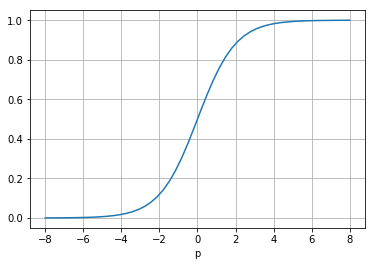

In [27]:
x = np.linspace(-8,8,50)
print(x)
phi = (1)/(1+(np.exp(-x)))

plt.grid()
plt.xlabel("z")
plt.xlabel("p")
plt.plot(x,phi)
plt.show()

First we need to convert this into a binary classification model. As the glass types range from 1 to 7, we map types 1,2,3 > 0 and 5,6,7 > 1. There are no samples with type 4. We then plot this dataset to see if the mapping is a fair approximation:

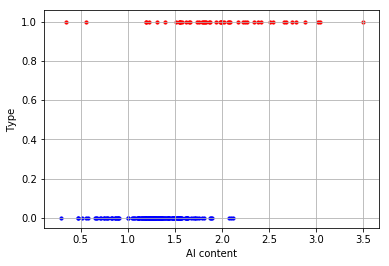

In [28]:
#maps Types 1-3 as 0 and 5-7 as 1
dataset['binary'] = dataset.Type.map({1:0, 2:0, 3:0, 5:1, 6:1, 7:1})
data = np.stack((dataset["Al"], np.full_like(dataset["Al"],1),dataset["binary"]), axis=-1)

#Al is the x value, anything with type 1,2,3 > 0, and type 4,5,6 > 1
df_Al_data = pd.DataFrame(columns = ['Al','const','label'])
df_Al_data['Al'] = dataset["Al"]
df_Al_data['const'] = 1
df_Al_data['label'] = dataset['binary']

plt.grid()
plt.xlabel('Al content')
plt.ylabel('Type')
plt.scatter(df_Al_data['Al'][df_Al_data['label'] == 1],df_Al_data['label'][df_Al_data['label'] == 1],10,c='red')
plt.scatter(df_Al_data['Al'][df_Al_data['label'] == 0],df_Al_data['label'][df_Al_data['label'] == 0],10,c='blue')




We define the training and test data, to make life easier later on:

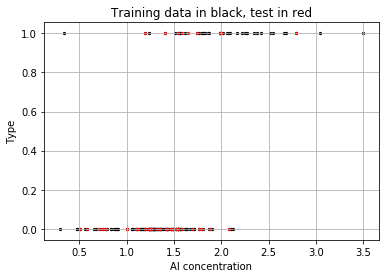

In [29]:
train = np.array(df_Al_data.sample(frac = 0.8))
test = np.array(df_Al_data.sample(frac = 0.2))
    
X_train = train[:,0:2] #notice it's in 2 dimensions
weights = np.transpose([[0.2, 0.5]]) #randomly chosen
Y_train = train[:,[2]] #notice it's in 2 dimensions

X_test =  test[:,0:2]
Y_test = test[:,[2]]

plt.grid()
plt.title("Training data in black, test in red")
plt.ylabel("Type")
plt.xlabel("Al concentration")
plt.scatter(X_train[:,0],Y_train,5,c='black')
plt.scatter(X_test[:,0],Y_test,5,c='red')

Define the sigmoid function. Then define a function that converts features (inputs) and weights into labels (outputs) through the sigmoid function.

In [30]:
def logit(z):
    phi = (1)/(1+(np.exp(-z)))
    return phi

def predict(features,weights):
    z = np.dot(features,weights)
    return logit(z)


Write a ```cost_function``` function to calculate the log loss or 'cost' of the predictions in comparison with the actual labels. The basis of this equation is the maximum likelihood estimate - here is are a few rows in its derivation:

Assuming the input data has a single independent variable $x$ (feature) and a binary outcome $y$, the maximum likelihood $L(\alpha_0, \alpha_1)$ becomes: 

$$L(\alpha_0, \alpha_1) = \prod_{i} P(x_i)^{y_i}\left(1-P(x_i)\right)^{1-y_i},$$

where the product runs over all the datapoints $i$, and $P(\vec{x})$ is the logistic probability function. Log-likelihood can then be expressed as: 

$$l(\alpha_0,\alpha_1) = \sum_{i=1}^n - \log\left(1 + \exp({\alpha_0 + \alpha_1 x_i})\right) + \sum_{i=1}^n y_i(\alpha_0 + \alpha_1 x_i),$$

and the partial derivatives of the log-likelihood:


$$\frac{\partial l}{\partial \alpha_0} = -\sum_{i=1}^n y_i - P(x_i; \alpha_0, \alpha_1)\qquad\text{and}\qquad \frac{\partial l}{\partial \alpha_1} = -\sum_{i=1}^n \left(y_i - P(x_i; \alpha_0, \alpha_1)\right)x_{i}$$

BTW: P(...) here is the same as logit($\alpha_1.x$ + $\alpha_0$)

As before, to find the optimal parameters $\alpha_0, \alpha_1$ we will code a function minimiser. In the previous lecture you have coded a simple gradient-descent, we will quickly go through the process again. The more confident can google the newton-raphson minimiser and implement it instead.

https://ml-cheatsheet.readthedocs.io/en/latest/logistic_regression.html

In [31]:
def cost_function(features,labels,weights):
    datapoints = len(labels) #2000 datapoints
    '''labels: [2000 1]'''
    '''labels: [2000 1]'''
    '''weights: [2 1]'''
    '''predicted: [2000' 1]'''
    predicted = predict(features,weights) #[2000 1]
    
    #error when label = 1
    cost_1 = -labels*np.log(predicted) #should give [2000 1], 1 number for each data point
    #error when label = 0
    cost_2 = -((1-labels)*np.log(1-predicted)) #again, this isnot matrix multiplication
    
    total_cost = cost_1+cost_2
    average_cost = np.sum(total_cost)/datapoints
    
    return average_cost #average_cost: [1 1]



If we say the sigmoid function is P(z) (as it gives the probability of the sample being type 1 given a certain z value), then the maximum likelihood derivative, i.e. the cost function derivative can be written as:

$$\frac{\partial \boldsymbol l}{\partial \boldsymbol \alpha} = -\sum_{i=1}^n x_i \times (\boldsymbol y_i - P(\boldsymbol z))$$

Where $ \boldsymbol \alpha \text{ represents } \alpha_0 \text{ and } \alpha_1. $ This is essentially the gradient that we use for gradient descent to find the optimum weights for this problem.

Write a function to figure out the cost function derivative with respect to the weights, and then update the weights accordingly:

In [32]:
def update_weights(features,labels,weights,learning_rate):
    """ features: [2000 2] (even if the second column is just 1s, for the bias term)
    labels: [2000 1]
    weights: [2 1]"""
    
    predicted = predict(features,weights) #predicted: [2000 1]
    N = len(features)
    
    cost_derivative = np.dot(features.T, (predicted - labels)) #outputs 2 by 1 matrix
    #with the cost derivative with respect to each weight
    """cost_derivative = [2 1]"""
    weights = weights - (cost_derivative/N)*learning_rate
    return weights



Now, we need to write code to classify our predictions. Logistic regression gives us a probability that any given sample belongs to the label 0 or 1. If this probability is higher than a certain number, we convert the class label to 1 and otherwise, convert it to 0. This number can be heuristically determined based on the training set, though we must be careful not to overfit to the training data.


In [33]:
def decision_boundary(prob):
    return 1 if prob >= .7 else 0

decision_boundary = np.vectorize(decision_boundary)

def classify(preds):
    return decision_boundary(preds).flatten()


Finally, we can begin training on our dataset! This piece of code iterates through the logistic regression algorithm (using Gradient Descent):
- First, predict the labels given the current weights
- Calculate the cost derivative based on predictions
- Update the weights based on the cost derviative
- Repeat until convergence
    
    

In [34]:
def minimize(features, labels, weights, lr, iters):
    cost_history = []
    for i in range(iters):
        weights = update_weights(features, labels, weights, lr)

        #Calculate error for auditing purposes
        cost = cost_function(features, labels, weights)
        cost_history.append(cost)
        # Log Progress
        #if i % 1000 == 0:
         #   print("iter: "+str(i) + " cost: "+str(cost))

    return weights, cost_history


Calculate the accuracy of predictions:

In [35]:
def accuracy(predicted_labels, actual_labels):
    diff = predicted_labels - actual_labels
    return 1.0 - (float(np.count_nonzero(diff)) / len(diff))

Plot cost history:

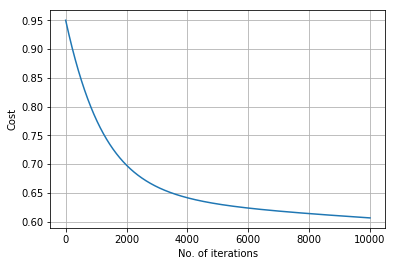

In [36]:
fin_weights, cost_history = minimize(X_train,Y_train,weights,0.0005,10000)
plt.figure()
plt.grid()
plt.xlabel("No. of iterations")
plt.ylabel("Cost")
plt.plot(cost_history)


Plot the test labels, test probabilities, and the labels that we mapped the probabilities to on a graph. Also calculate the accuracy of the model and display it below.

Accuracy:  79.07 %


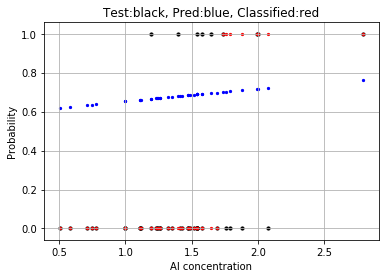

In [38]:

plt.grid()
Y_pred = predict(X_test,-fin_weights)
Y_pred_labs = classify(Y_pred)

plt.title("Test:black, Pred:blue, Classified:red")
plt.xlabel('Al concentration')
plt.ylabel('Probability')

plt.scatter(X_test[:,0],Y_test,10,c='black')
plt.scatter(X_test[:,0],Y_pred,5,c='blue') #should be curved? Couldn't find the error.
plt.scatter(X_test[:,0],Y_pred_labs,5,c='red')

acc = accuracy(Y_pred_labs,Y_test[:,0])
print("Accuracy: ", round((100*acc),2),"%")

# 3. Comparison to scikitlearn implementation

Here we show just how much easier it is to implement logistic regression in scikit-learn, with a prepared library and helper functions, which helps us appreciate the complexity of scikit-learn. Nonetheless, this also shows that without a good understanding of the fundamentals and behind-the-scenes mathematics of these libraries, it is difficult to utilise them to their full potential.


Accuracy:  83.72 %


/Users/arohan/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


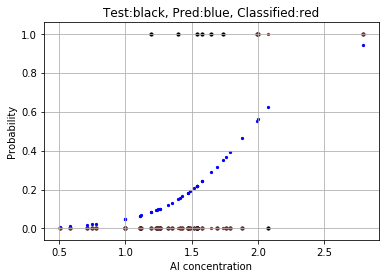

In [39]:
X_train_2D = np.reshape(X_train[:,0],(len(X_train),1))
X_test_2D = np.reshape(X_test[:,0],(len(X_test),1))

model = LogisticRegression(penalty='l2', solver='newton-cg')
model.fit(X_train_2D,Y_train)

Y_pred_sk = model.predict(X_test_2D)
Y_pred_prob = model.predict_proba(X_test_2D)

acc = accuracy(Y_pred_sk,Y_test[:,0])
print("Accuracy: ", round((100*acc),2),"%")

plt.grid()
plt.title("Test:black, Pred:blue, Classified:red")
plt.xlabel('Al concentration')
plt.ylabel('Probability')

plt.scatter(X_test[:,0],Y_test,10,c='black')
plt.scatter(X_test[:,0],Y_pred_prob[:,1],5,c='blue')
plt.scatter(X_test[:,0],Y_pred_sk,5,c='red')
